In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")


In [2]:
dis_threshold = 10
trans_possibility = 0.5
Total_time = 1 * 60 * 1000
Trans_time = 5 * 1000
Rest_time = 5 * 1000

In [3]:
class Seat:
    def __init__(self, x = None, y = None, proba = 0, anc = [], ident = 'Empty', l = None):
        self.x = x
        self.y = y
        self.probability = proba
        self.ancestor = anc
        self.identity = ident
        self.label = l
        
    def set_x(self, x):
        self.x = x

    def set_y(self, y):
        self.y = y
    
    def set_pros(self, p):
        self.probability = p

    def set_ancestor(self, anc):
        self.ancestor = anc
    
    def set_identity(self, ident):
        self.identity = ident
        
    def set_label(self, l):
        self.label = l
        self.set_pros(1 - math.pow((1 - math.pow(trans_possibility, l)), (Total_time / (Trans_time + Rest_time))))
        
    def to_string(self):
        print("Seat x:" + str(self.x) + " y:" + str(self.y) + " has ancestor " + str(self.ancestor) + " and label " + str(self.label) + " which is occupied by " + str(self.identity))

In [4]:
# identity: Empty, Teacher, Student

In [5]:
def cal_dis(x1,y1,x2,y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

In [6]:
class Class:

    def __init__(self, length = -1, width= -1):
        self.seat_length = length
        self.seat_width = width
        
        seat_list = []
        for l in range(length):
            for w in range(width):
                seat_list.append(Seat(w,l, ident="Empty"))
        self.class_seats = seat_list
        self.teacher_x = self.seat_width / 2
        self.teacher_y = -1
#         self.class_seats.append(Seat(self.teacher_x, self.teacher_y, ident="Teacher"))
        self.max_label = math.ceil(math.sqrt(self.seat_length*self.seat_length + self.seat_width*self.seat_width)/dis_threshold) + 1
        # max_label means the maximum number of label which this class can have
        
    def get_seat(self, x, y):
        return self.class_seats[x + (y * self.seat_width)] # return the Seat OBJECT
    
    def convert_index_to_xy(self,index):
        x = index % self.seat_width
        y = math.floor(index / self.seat_width)
        return x, y
    
    def convert_xy_to_index(self, x, y):
        return x + (y * self.seat_width)
    
    def random_arrange_student(self, student_num):
        """
        Randomly arrange students for this class
        student_number: Number of students in this class
        """
        if len([self.return_all_student_seat()]) > 0:
            # If there are already students in this class
            # Reset all the seats in this class
            self.class_seats = []
            for l in range(self.seat_length):
                for w in range(self.seat_width):
                    self.class_seats.append(Seat(w,l, ident="Empty"))
        arr = np.arange(self.seat_length * self.seat_width)
        np.random.shuffle(arr)
        
        for index in arr[:student_num]:
            self.class_seats[index].set_identity("Student")

    def return_all_student_seat(self):
        res = [] 
        for i in self.class_seats:
            if (i.identity == "Student"):
                res.append(i)
        # res = [Seat1_object, Seat2_object, Seat3_object,....]
        return res
    
    def visualize_students(self):
        """
        Visualize all the student seats in this class
        """
        students = self.return_all_student_seat()
        arr = np.array([[0] * self.seat_width] * self.seat_length) # Initializa a 2d-array with class_width * class_length, initial value is 0
        for s in students:
            arr[s.y][s.x] = 1
            
        # Draw the heatmap
        plt.figure(figsize=(self.seat_length/2, self.seat_width/2))
        sns.heatmap(pd.DataFrame(arr).sort_index(ascending=False), square=True, linewidths=0.5, cmap="YlGnBu")
        plt.show()
        return arr
    
    def visualize_selected_seats(self, seats_list):
        arr = np.array([[0] * self.seat_width] * self.seat_length)
        for s in seats_list:
            arr[s.y][s.x] = 1
        
        plt.figure(figsize=(self.seat_length/2, self.seat_width/2))
        sns.heatmap(pd.DataFrame(arr).sort_index(ascending=False), square=True, linewidths=0.5, cmap="YlGnBu")
        plt.show()
        return arr
    
    def set_ancestor(self):
        """
        Set ancestor for all the student seats in this class
        """
        students = self.return_all_student_seat()
        students_label = np.array([i.label for i in students])
        if (all(x == None for x in students_label)): # if the student labels are all None
            print("Set label 1 and ancestor to teacher for students who is near to teacher")
            for i in students:
                if cal_dis(i.x,i.y,self.teacher_x,self.teacher_y) < dis_threshold:
                    i.set_ancestor("Teacher")
                    i.set_label(1)

        count = 0
        while (True):
            students_without_ancestor = [i for i in students if len(i.ancestor) == 0]
            students_with_ancestor = [i for i in students if len(i.ancestor) != 0]
            if len(students_without_ancestor) == 0:
                print("All the students have ancestors now")
                break
            if count > self.max_label:
                print(students_without_ancestor)
                print("There are students cannot be reached by anyone!!!!!")
                break

            for a in students_without_ancestor:
                nearby = []
                for b in students_with_ancestor:
                    if cal_dis(a.x,a.y,b.x,b.y) < dis_threshold:
                        nearby.append(b)
                if len(nearby) > 0:
                    ancestor_label = min([j.label for j in nearby])
                    a.set_label(ancestor_label + 1)
                    for i in nearby:
                        if (i.label == ancestor_label):
                            a.ancestor.append('Stu' + str([i.x, i.y]))

            count += 1
            
    def visualize_seats_label(self):
        students = self.return_all_student_seat()
        arr = np.array([[0] * self.seat_width] * self.seat_length)
        for s in students:
            if s.label is None:
                print("There are students cannot be reached by Teacher")
                arr[s.y][s.x] = self.max_label + 1
            else:
                arr[s.y][s.x] = s.label

        plt.figure(figsize=(self.seat_length/2, self.seat_width/2))
        sns.heatmap(pd.DataFrame(arr).sort_index(ascending=False), square=True, linewidths=0.5, cmap=sns.cubehelix_palette(self.max_label+1, start=2, rot=1, dark=0, light=.95))
        plt.show()
        
        return arr

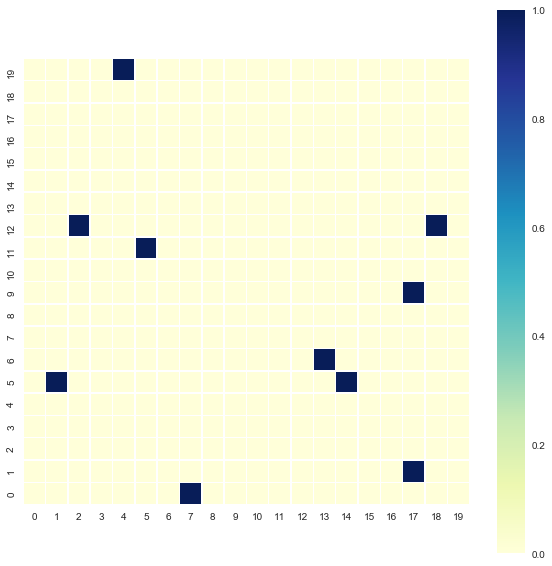

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
A = Class(20, 20)
A.random_arrange_student(10)
A.visualize_students()

Set label 1 and ancestor to teacher for students who is near to teacher
All the students have ancestors now
There are students cannot be reached by Teacher
There are students cannot be reached by Teacher


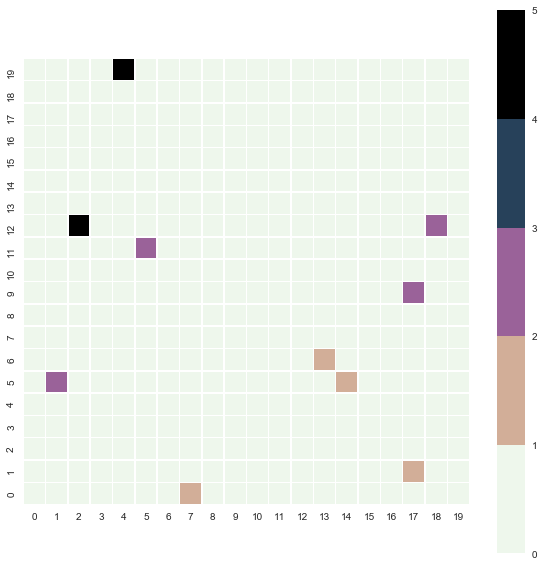

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
A.set_ancestor()
A.visualize_seats_label()

In [9]:
A_students = A.return_all_student_seat()
for i in A_students:
    i.to_string()

Seat x:7 y:0 has ancestor Teacher and label 1 which is occupied by Student
Seat x:17 y:1 has ancestor Teacher and label 1 which is occupied by Student
Seat x:1 y:5 has ancestor ['Stu[7, 0]', 'Stu[17, 1]', 'Stu[14, 5]', 'Stu[13, 6]', 'Stu[13, 6]', 'Stu[14, 5]', 'Stu[13, 6]'] and label 2 which is occupied by Student
Seat x:14 y:5 has ancestor Teacher and label 1 which is occupied by Student
Seat x:13 y:6 has ancestor Teacher and label 1 which is occupied by Student
Seat x:17 y:9 has ancestor ['Stu[7, 0]', 'Stu[17, 1]', 'Stu[14, 5]', 'Stu[13, 6]', 'Stu[13, 6]', 'Stu[14, 5]', 'Stu[13, 6]'] and label 2 which is occupied by Student
Seat x:5 y:11 has ancestor ['Stu[7, 0]', 'Stu[17, 1]', 'Stu[14, 5]', 'Stu[13, 6]', 'Stu[13, 6]', 'Stu[14, 5]', 'Stu[13, 6]'] and label 2 which is occupied by Student
Seat x:2 y:12 has ancestor ['Stu[7, 0]', 'Stu[17, 1]', 'Stu[14, 5]', 'Stu[13, 6]', 'Stu[13, 6]', 'Stu[14, 5]', 'Stu[13, 6]'] and label None which is occupied by Student
Seat x:18 y:12 has ancestor ['S